# Chapter 3 Exercises

In [1]:
import os
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

from IPython.display import SVG, display
from pandas.plotting import parallel_coordinates
from scipy import stats
from theano import shared, tensor

np.random.seed(seed=0)
az.style.use('arviz-darkgrid')

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


## Question 1
***

*Check the following definition of a probabilistic model. Identify the likelihood, the prior and the posterior:*

\begin{eqnarray}
y_i \text{~} Normal(\mu, \sigma) \newline
\mu \text{~} Normal(0,10) \newline
\sigma \text{~} \left|Normal(0,25) \right|
\end{eqnarray}

The priors in this model are:

\begin{eqnarray}
\mu \text{~} Normal(0,10) \newline
\sigma \text{~} \left|Normal(0,25) \right|
\end{eqnarray}


The likelihood in our model is  :
$$ Normal(\mu, \sigma)$$

And the posterior will be a distribution over $\mu$ and $\sigma$, but the posterior is not directly specified in the model (it is the result of Bayes formula!).

## Question 2
***

*For the model in exercise 1, how many parameters will the posterior have? In other words, how many dimensions will it have?*

There are two parameters in this model: $\mu$ and $\sigma$. So the posterior is 2-dimensional.

## Question 3
***

*Write Bayes' theorem for the model in exercise 1.*

Without expanding the denominator:

$$ p(\mu, \sigma | y) = \frac{\Pi_i\; \bigg( Normal(y| \mu, \sigma)\quad Normal(\mu|0,10)\quad HalfNormal(\sigma|0,25) \bigg) }{p(y)}  $$

Expanding the denominator:
$$ p(\mu, \sigma | y) = \frac{\Pi_i\; \bigg( Normal(y| \mu, \sigma)\quad Normal(\mu|0,10)\quad HalfNormal(\sigma|0,25) \bigg) }{\int \int\; \Pi_i\; \bigg( Normal(y| \mu, \sigma)\quad Normal(\mu|0,10)\quad HalfNormal(\sigma|0,25) \bigg)\; d\mu\; d\sigma} $$

## Question 4
***

*Check the following model. Identify the linear model and the likelihood. How many parameters does the posterior have?*

\begin{eqnarray}
y \text{~} Normal(\mu, \epsilon) \newline
\mu = \alpha + \beta x \newline
\alpha \text{~} Normal(0,10) \newline
\beta \text{~} Normal(0,1) \newline
\epsilon \text{~} \left|Normal(0,25) \right|
\end{eqnarray}

The linear model is:
\begin{eqnarray}
\mu = \alpha + \beta x
\end{eqnarray}


The likelihood in our model is:  
$$ Normal(\mu, \epsilon)$$

The posterior will have three parameters:

$$ \alpha, \beta, \epsilon $$

## Question 5
***

*For the model in exercise 1, assume that you have a dataset with 57 data points coming from a Gaussian with a mean of 4 and a standard deviation of 0.5. Using PyMC3, compute:*
- The posterior distribution
- The prior distribution
- The posterior predictive distribution
- The prior predictive distribution

*Tip: Besides `pm.sample()`, PyMC3 has other functions to compute samples.*

For this exercise we will generate 57 datapoints from a distribution of $Normal(4, 0.5)$:

In [3]:
data = stats.norm(4,.5).rvs(size=57)

In [4]:
with pm.Model() as model:
    mu = pm.Normal("mu", 0, 10)
    sd = pm.HalfNormal("sd", 25)
    y = pm.Normal("y,", mu, sd, observed=data)
    
    # Compute both prior, and prior predictive
    prior_predictive = pm.sample_prior_predictive()
    
    # Compute posterior
    trace = pm.sample()
    
    # Compute posterior predictive
    posterior_predictive = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, mu]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:01<00:00, 1084.35draws/s]
The acceptance probability does not match the target. It is 0.8806704207811868, but should be close to 0.8. Try to increase the number of tuning steps.
100%|██████████| 1000/1000 [00:00<00:00, 1292.64it/s]


In [6]:
dataset = az.from_pymc3(trace=trace, posterior_predictive=posterior_predictive, prior=prior_predictive)
dataset

Inference data with groups:
	> posterior
	> sample_stats
	> posterior_predictive
	> prior
	> observed_data

Let's plot the prior distributions to get a sense of what the Bayesian model's estimations without data

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c1b207cc0>,
      dtype=object)

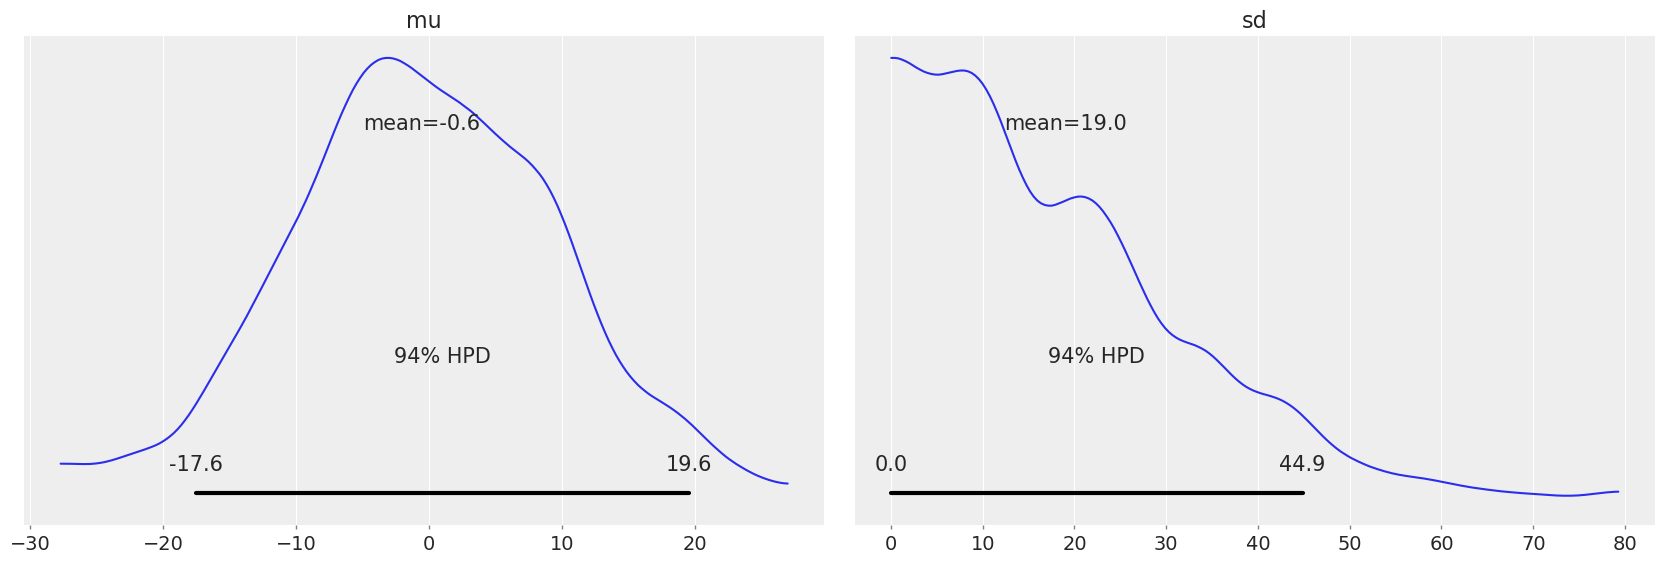

In [7]:
# The plot_posterior method can be used to plot priors as well
az.plot_posterior(dataset.prior, var_names=["mu", "sd"]);

Now let's plot the posterior, to check the distributions after update:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c282e27b8>,
      dtype=object)

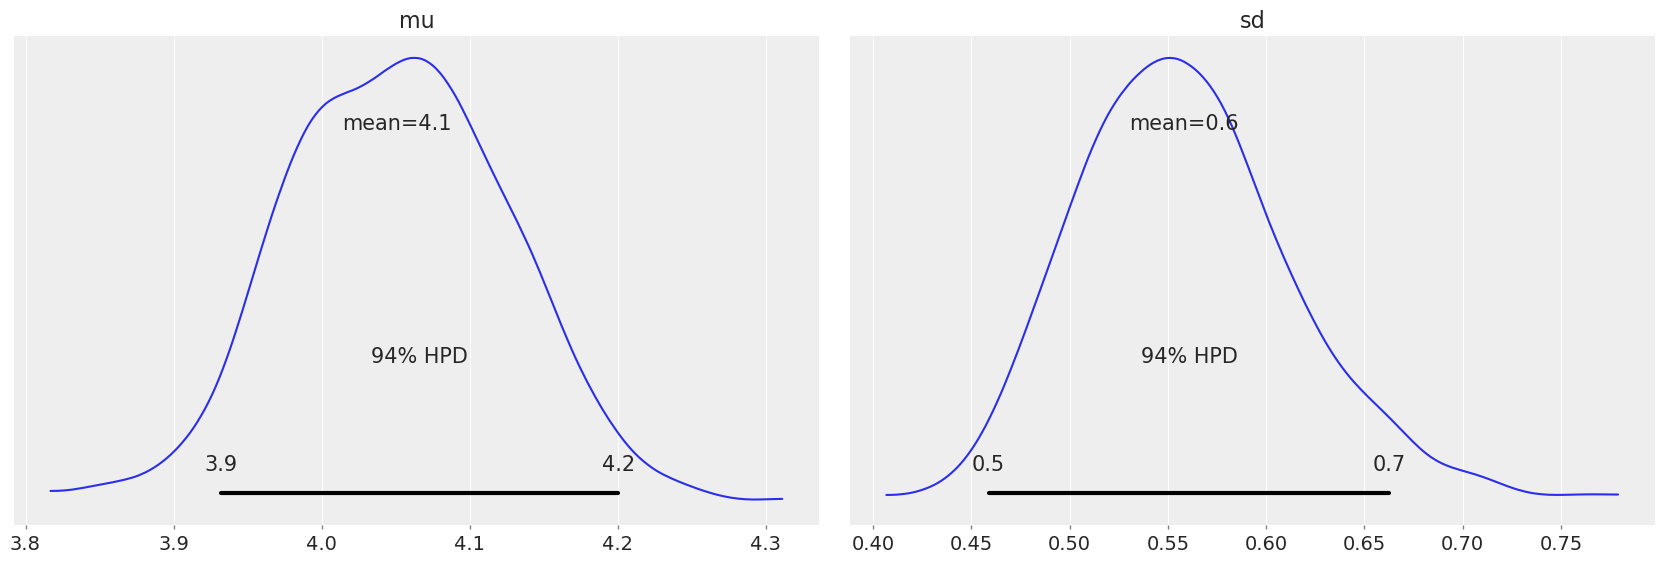

In [8]:
# Compare above plot to posterior distribution below, as well as to original parameters in distribution
az.plot_posterior(dataset)

The exercise also asks for the prior predictive values. We'll need to do some data manipulation to get the data into a format we can use with ArviZ:

In [9]:
dataset.prior

<xarray.Dataset>
Dimensions:   (chain: 1, draw: 500, y,_dim_0: 57)
Coordinates:
  * chain     (chain) int64 0
  * draw      (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * y,_dim_0  (y,_dim_0) int64 0 1 2 3 4 5 6 7 8 ... 48 49 50 51 52 53 54 55 56
Data variables:
    sd        (chain, draw) float64 0.5084 33.7 19.04 ... 79.27 4.737 33.71
    y,        (chain, draw, y,_dim_0) float64 3.632 2.833 1.979 ... -33.26 11.49
    mu        (chain, draw) float64 3.025 -6.343 -3.627 ... -6.78 12.98 -23.64
    sd_log__  (chain, draw) float64 -0.6766 3.517 2.947 ... 4.373 1.556 3.518
Attributes:
    created_at:                 2019-03-16T02:34:03.270827
    inference_library:          pymc3
    inference_library_version:  3.6

Let's also plot the prior predictive values, we'll need to do some data manipulation to get the data into a format we can use with ArviZ

In [10]:
print(dataset.prior["y,"].values.shape)
prior_predictive = dataset.prior["y,"].values.flatten()
prior_predictive.shape

(1, 500, 57)


(28500,)

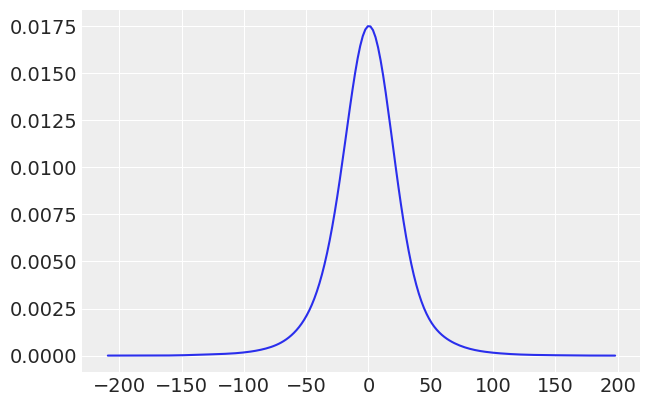

In [11]:
az.plot_kde(prior_predictive);

We can them compare this to the posterior predictive distribution:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c28da19b0>],
      dtype=object)

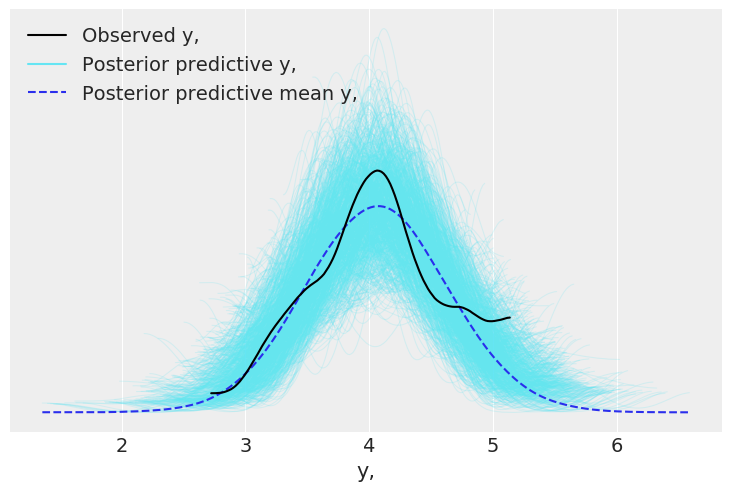

In [12]:
az.plot_ppc(dataset);

## Question 6
***

*Execute `model_g` using NUTS (the default sampler) and then using Metropolis. Compare the results using ArviZ functions like `plot_trace` and `plot_pairs`. Center the variable $x$ and repeat the exercise. What conclusion can you draw from this?*

In [3]:
np.random.seed(1)
N = 100
alpha_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)

x = np.random.normal(10, 1, N)
y_real = alpha_real + beta_real * x
y = y_real + eps_real

In [4]:
with pm.Model() as model_g:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = pm.Deterministic('μ', α + β * x)
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

In [5]:
%%time
with model_g:
    trace_nuts_non_centered = pm.sample(draws=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β, α]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:07<00:00, 316.12draws/s]
The acceptance probability does not match the target. It is 0.8790052122255555, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


CPU times: user 3.09 s, sys: 565 ms, total: 3.65 s
Wall time: 12.9 s


In [6]:
nuts_non_centered_dataset = az.from_pymc3(trace=trace_nuts_non_centered)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c147f8c50>,
      dtype=object)

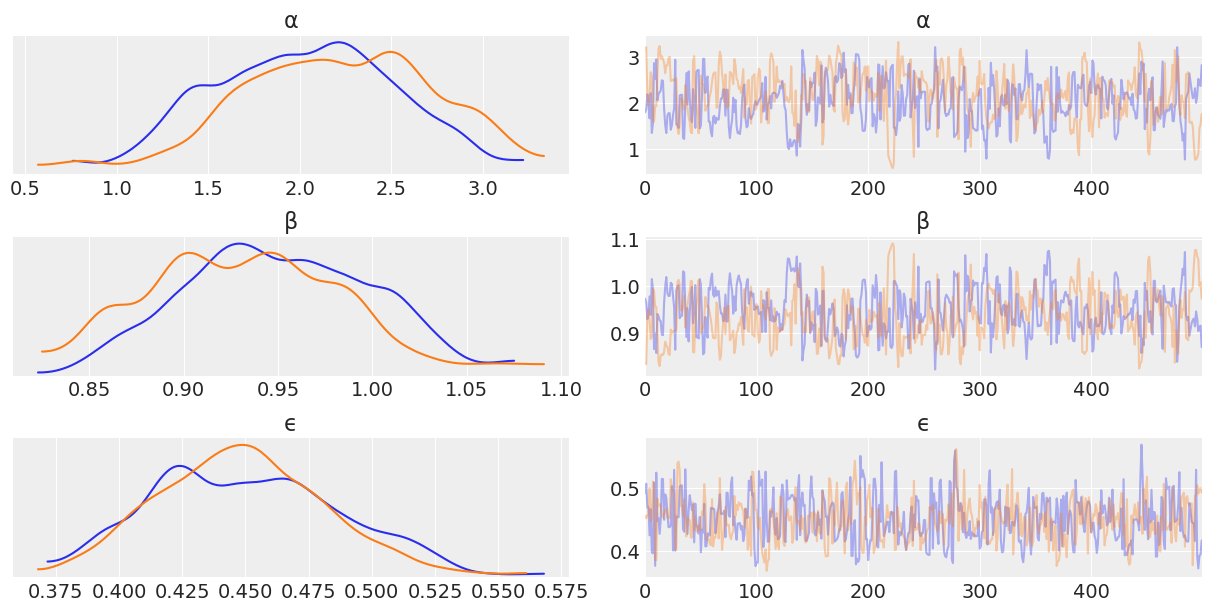

In [7]:
az.plot_trace(trace_nuts_non_centered, var_names=['α', 'β', 'ϵ']);

[array([[<matplotlib.axes._subplots.AxesSubplot object at 0x105f21d68>,
       dtype=object),
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x105f21d68>,
       dtype=object),
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x105f21d68>,
       dtype=object)]

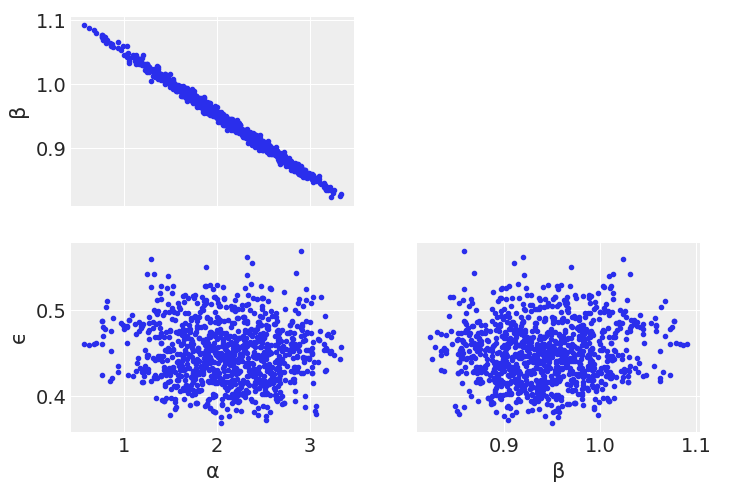

In [8]:
az.plot_pair(trace_nuts_non_centered, var_names=['α', 'β', 'ϵ']);

In [9]:
%%time
with model_g:
    step = pm.Metropolis()
    trace_mh_non_centered = pm.sample(draws=500, step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [ϵ]
>Metropolis: [β]
>Metropolis: [α]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:01<00:00, 1594.40draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


CPU times: user 2.31 s, sys: 249 ms, total: 2.56 s
Wall time: 3.26 s


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c13cdbeb8>,
      dtype=object)

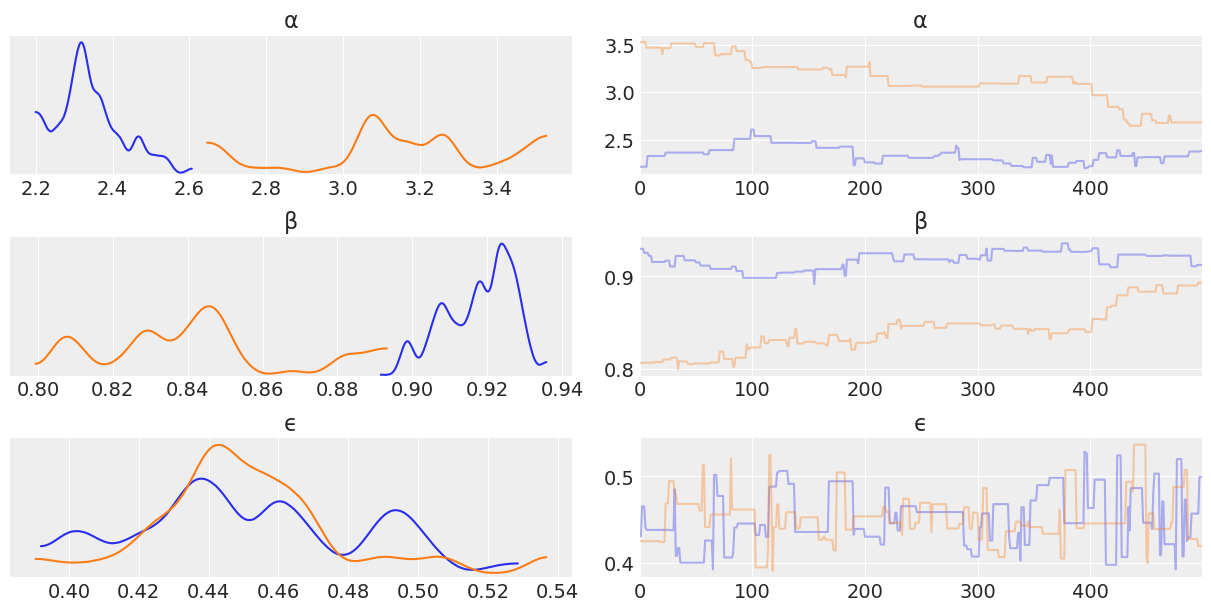

In [10]:
az.plot_trace(trace_mh_non_centered, var_names=['α', 'β', 'ϵ']);

In [11]:
az.summary(trace_nuts_non_centered, var_names=['α', 'β', 'ϵ'])

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
α,2.10,0.53,0.05,1.13,3.03,143.0,1.02
β,0.94,0.05,0.00,0.85,1.03,140.0,1.02
ϵ,0.45,0.04,0.00,0.39,0.52,503.0,1.00


In [12]:
az.summary(trace_mh_non_centered, var_names=['α', 'β', 'ϵ'])

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
α,2.74,0.43,0.15,2.21,3.47,1.0,3.27
β,0.88,0.04,0.01,0.81,0.93,1.0,3.14
ϵ,0.45,0.03,0.00,0.40,0.51,109.0,1.00


Now let's standardize the variables and take samples again. We don't need to redefine the model, but we'll do so for clarities sake:

In [13]:
# standardize the data
x_centered = (x - x.mean())/x.std()
y_centered = (y - y.mean())/y.std()

In [14]:
with pm.Model() as model_g_centered:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = pm.Deterministic('μ', α + β * x_centered)
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_centered)

In [15]:
%%time
with model_g_centered:
    trace_nuts_centered = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β, α]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 770.39draws/s] 

CPU times: user 2.59 s, sys: 218 ms, total: 2.81 s
Wall time: 4.43 s


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c22edaeb8>,
      dtype=object)

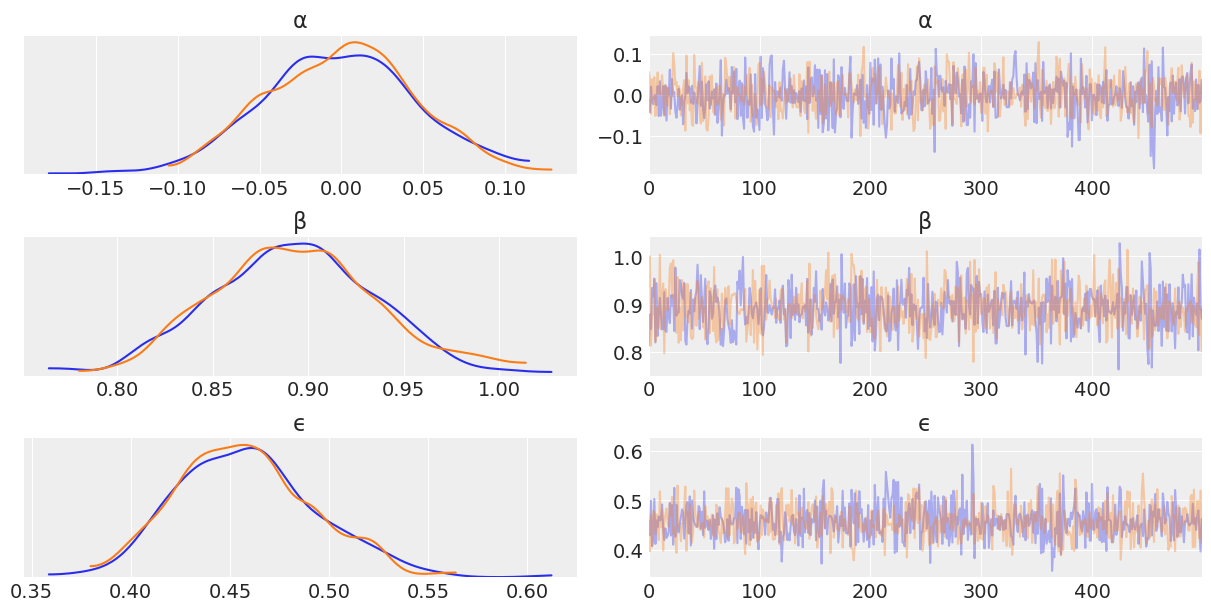

In [16]:
az.plot_trace(trace_nuts_centered, var_names=['α', 'β', 'ϵ']);

[array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c234bd898>,
       dtype=object),
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c234bd898>,
       dtype=object),
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c234bd898>,
       dtype=object)]

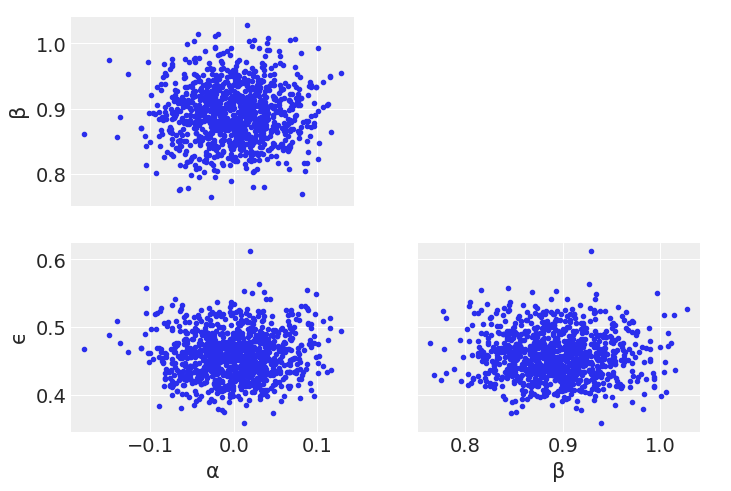

In [17]:
az.plot_pair(trace_nuts_centered, var_names=['α', 'β', 'ϵ']);

In [18]:
%%time
with model_g_centered:
    step = pm.Metropolis()
    trace_mh_centered = pm.sample(step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [ϵ]
>Metropolis: [β]
>Metropolis: [α]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:01<00:00, 1409.95draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


CPU times: user 2.14 s, sys: 192 ms, total: 2.33 s
Wall time: 2.96 s


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c23b678d0>,
      dtype=object)

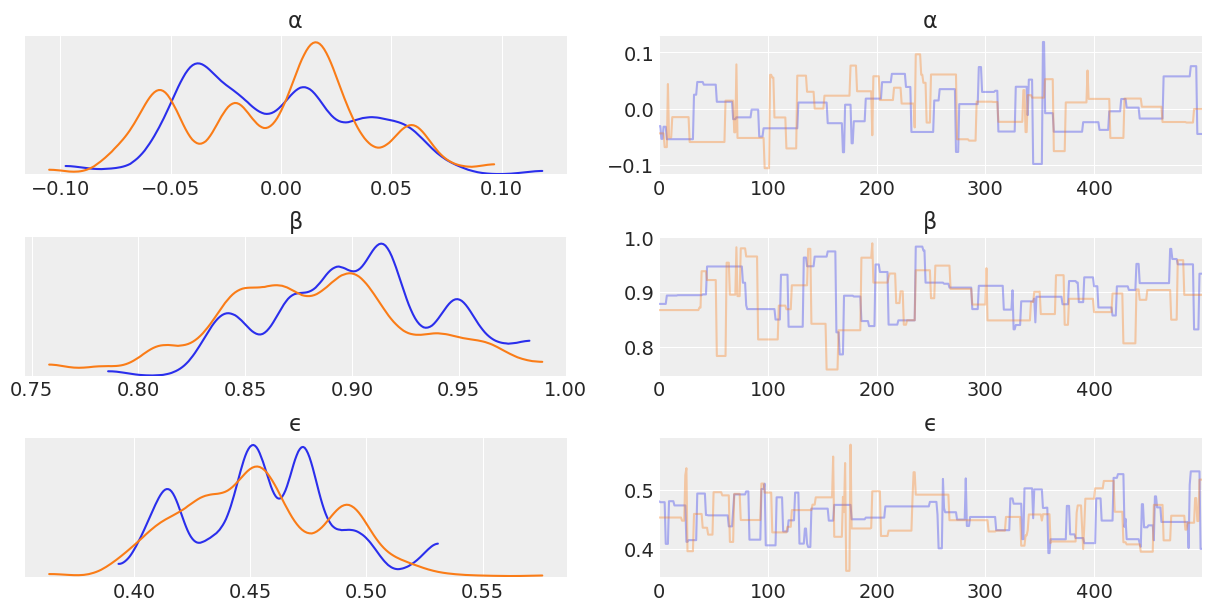

In [19]:
az.plot_trace(trace_mh_centered, var_names=['α', 'β', 'ϵ'])

[array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2418aeb8>,
       dtype=object),
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2418aeb8>,
       dtype=object),
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2418aeb8>,
       dtype=object)]

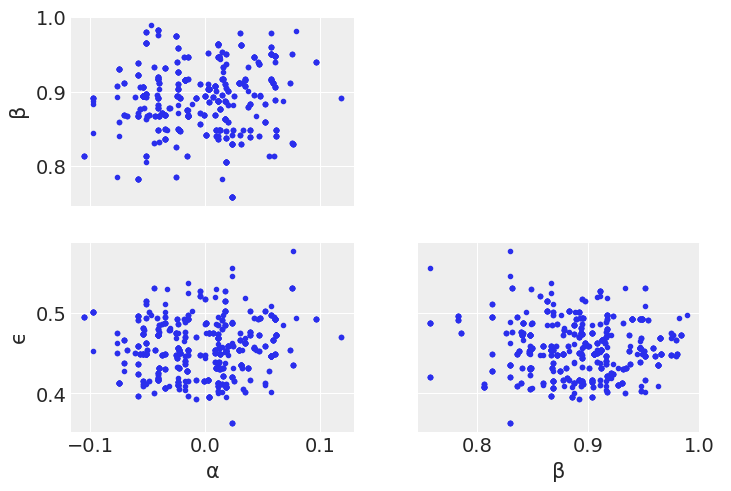

In [20]:
az.plot_pair(trace_mh_centered, var_names=['α', 'β', 'ϵ']);

Looking through the plots there's a couple things to note.

Metropolis Hastings is less effective at sampling than NUTS. This is indicated by:
 1. The Metropolis Hasting trace plots looking "square" when compared the NUTS traceplot. This is due to the sampler getting "stuck" at a value.
 2. The kernel density estimates of each chain have "squiggly" topologies
 3. The effective number of samples for Non Centered Metropolis Hastings is 1
 
One thing to note though is that Metropolis Hastings does sample faster than NUTS. While the results aren't great, credit is due where it's deserved!
 
Diving into the problem further, we can see that $\alpha$ and $\beta$ are linearly correlated. Metropolis Hastings does not sample well when toplogies have such shapes. We'll talk more about this in Chapter 8, but for now note how centering x helps somewhat with the Metropolis Hasting sampler, as centering decorrelates $\alpha$ and $\beta$ parameters.

The biggest takeaway is the effectiveness of NUTS, regardless of topology in these two cases. This is not to say NUTS can handle anything you throw at it, there are some topologies that are hard, but by and large NUTS does quite well in many situations.

## Question 7
***

*Use the howell dataset to create a linear model of the weight ($x$) against the height ($y$). Exclude subjects that are younger than 18. Explain the results.*

Let's import the dataset and create a mask for people older than 18:

In [21]:
howell = pd.read_csv("../code/data/howell.csv", delimiter=";")
howell.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


In [22]:
age_18_mask = howell["age"] > 18

A good first step is before diving into statistics is to look at the data and ask if it make sense. In my experience taller people tend to weigh more than shorter people. Let's check the data to be sure.

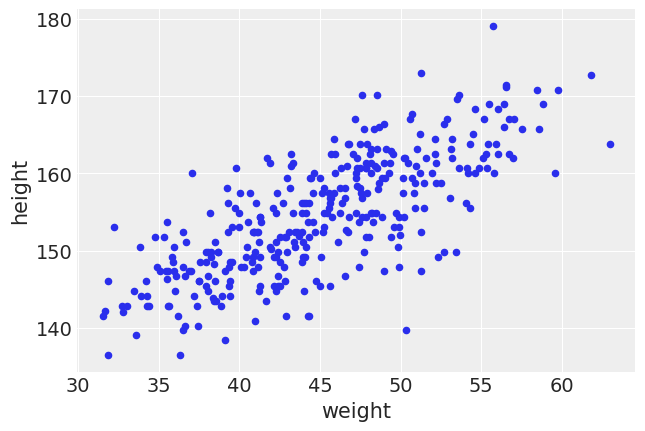

In [23]:
howell[age_18_mask].plot(kind="scatter", x="weight", y="height");

When looking at the plot above this is with consistent our expectations. As weight increases, height increases as well. From visual inspection, it looks like a linear fit with some noise is best. In this case we will assume constant variance. Let's create a model:

In [24]:
height = howell["height"]
weight = howell["weight"]

In [25]:
with pm.Model() as over_18_heights:
    α = pm.Normal("α", sd=10)
    β = pm.Normal("β", sd=10)
    ϵ = pm.HalfNormal("ϵ", sd=10)
    
    weight_shared = shared(weight[age_18_mask].values * 1.)
    μ = pm.Deterministic("μ", α+β*weight_shared)
    
    height_pred = pm.Normal("height_pred", mu=μ, sd=ϵ, observed = height[age_18_mask])
    trace_over_18_heights = pm.sample(tune=2000)
    ppc_over_18_heights = pm.sample_posterior_predictive(trace_over_18_heights, samples=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β, α]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:14<00:00, 347.37draws/s]
The acceptance probability does not match the target. It is 0.8949160386428021, but should be close to 0.8. Try to increase the number of tuning steps.
100%|██████████| 2000/2000 [00:02<00:00, 105.64it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c22802f60>,
      dtype=object)

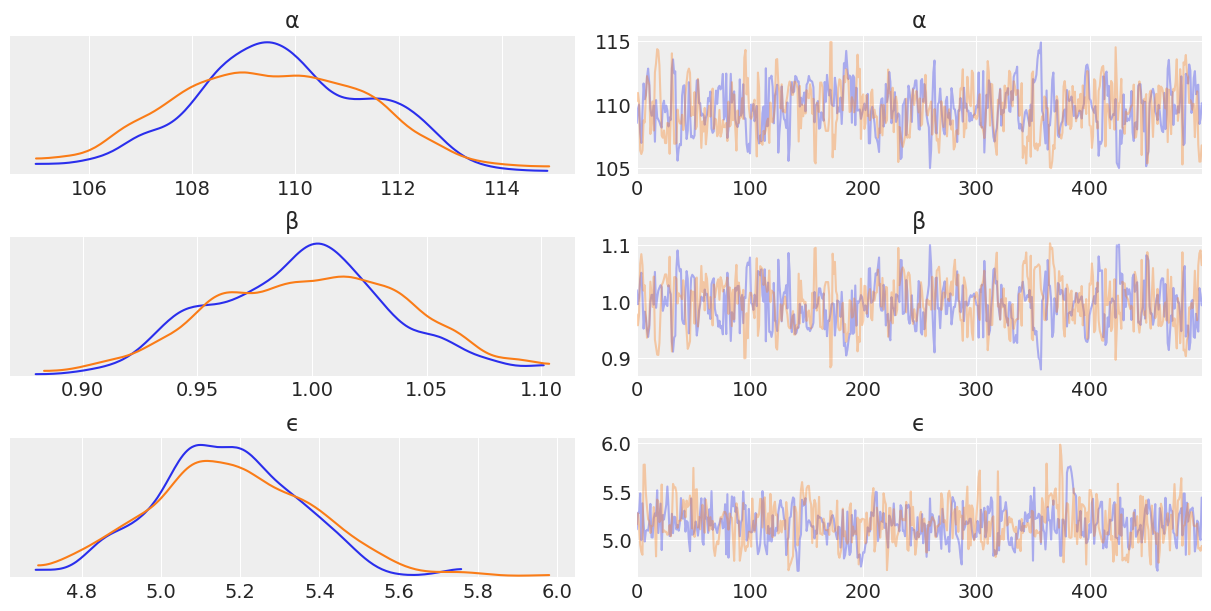

In [26]:
az.plot_trace(trace_over_18_heights, var_names = ["α","β", "ϵ"]);

Looking at the traceplot it looks like the inference engine was able to explore the posterior adequately. Let's plot the regression and the hpd.

Text(0.5, 0.98, 'Weight vs Height fit and posterior predictive checks')

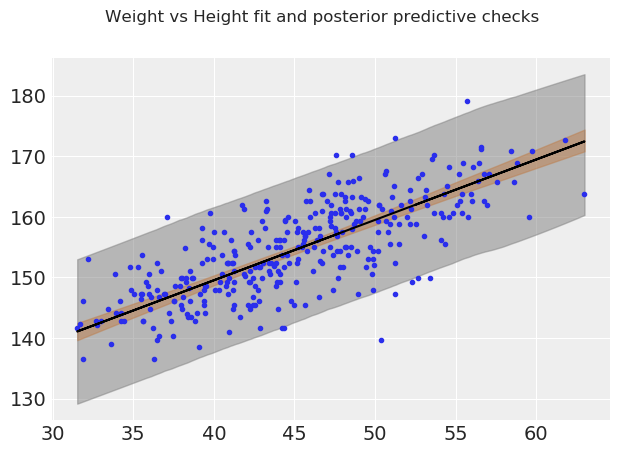

In [27]:
fig, ax = plt.subplots()

ax.plot(weight[age_18_mask], height[age_18_mask], "C0.")
μ_m = trace_over_18_heights["μ"].mean(0)
ϵ_m = trace_over_18_heights["ϵ"].mean()

ax.plot(weight[age_18_mask], μ_m, c="k")
az.plot_hpd(weight[age_18_mask], trace_over_18_heights["μ"], credible_interval=.98)
az.plot_hpd(weight[age_18_mask], ppc_over_18_heights["height_pred"], credible_interval=.98, color="gray")
fig.suptitle("Weight vs Height fit and posterior predictive checks");

From visual inspection the average parameters of the fit look quite good, and the 98% interval of the posterior predictive checks covers most of the distribution. Overall, it looks like a linear fit is great for height vs weight for people over 18!

## Question 8
***

*For four subjects, we get the weights (45.73, 65.8, 54.2, 32.59), but not their heights. Using the model from the previous exercise, predict the height for each subject, together with their 50% and 94% HPDs.*

*Tip 1: Check the [coal mining disaster example](https://docs.pymc.io/notebooks/getting_started.html#Case-study-2:-Coal-mining-disasters) in PyMC3's documentation.*

*Tip 2: Use shared variables.*

Using our previous fit, we can generate predictions for the height of people with various weights:

In [28]:
weights = (45.73, 65.8, 54.2, 32.59)

In [29]:
weight_shared.set_value([45.73])
ppc = pm.sample_posterior_predictive(trace_over_18_heights, samples=2000, model=over_18_heights)

100%|██████████| 2000/2000 [00:02<00:00, 885.08it/s]


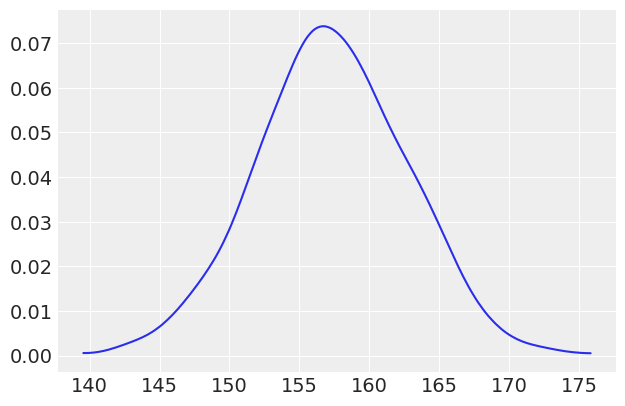

In [30]:
ppc_first_col = ppc["height_pred"][:,0]
az.plot_kde(ppc_first_col);

The reason we take the 0th column is that, in the current version of PyMC3, `pm.sample_ppc` returns an array of size $samples\; \times\; observed\; values$. This makes total sense when you want to do posterior predictive checks, as you want to check that the simulations/predictions have the  same size/shape as the observations. But when you just want to make predictions at values other that the input data, that restriction does not apply. In summary, I consider this a limitation of the current implementation of `pm.sample_ppc`.

## Question 9
***

*Repeat exercise 7, this time including those below 18 years old. Explain the results.*

Let's take a look at the data again, now without the age limit:

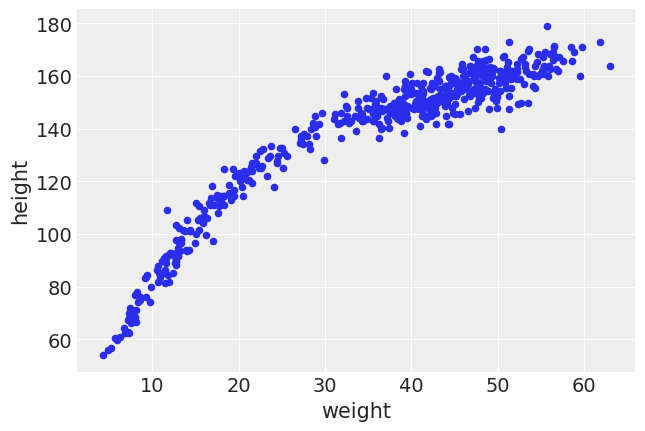

In [32]:
howell.plot(kind="scatter", x="weight", y="height");

By removing the age limit we notice a different trend. At lower weights, a single unit of weight generally corresponds to more height. At higher weights however the height still goes up, but by a lesser amount. There also seems to be more "spread" in the higher weights, than in the lower weights.

Intuitively again this makes sense. Weight is a proxy for age, and when born the variability in height and weight is smaller than for adults. Additionally children tend to grow in both height and weight. Once humans reach adulthood, the height is mostly fixed, and the weight unfortunately changes all too easily.

Another thing to note is the shape of the distribution: it no longer looks linear throughout, but instead looks more like a curve. We could use a square root linear fit, like earlier in the chapter, but we instead will use a logarithmic fit. We will also model the noise term to be correlated with weight, as heights seem to vary more when weights get higher.

In [33]:
with pm.Model() as heights:
    α = pm.Normal("α", sd=10)
    β = pm.Normal("β", sd=10)
    γ = pm.HalfNormal("γ", sd=10)
    δ = pm.HalfNormal("δ", sd=10)
    
    weight_shared = shared(weight.values * 1.)
    
    μ = pm.Deterministic("μ", α+β*tensor.log(weight_shared))
    ϵ = pm.Deterministic("ϵ", γ+δ*weight_shared)
    
    height_pred = pm.Normal("height_pred", mu=μ, sd=ϵ, observed = height)
    trace_heights = pm.sample(tune=2000)
    ppc_heights = pm.sample_posterior_predictive(trace_heights, samples=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [δ, γ, β, α]
100%|██████████| 2000/2000 [00:02<00:00, 947.82it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2be2c4e0>,
      dtype=object)

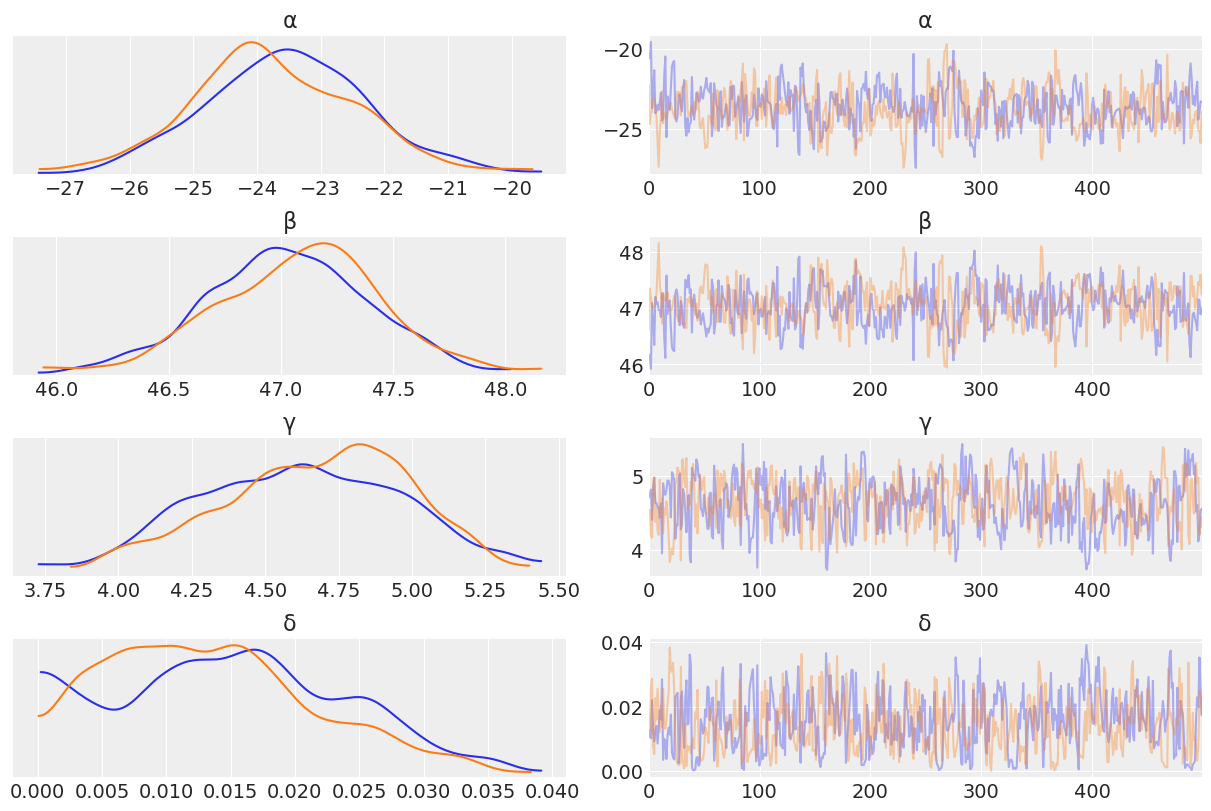

In [34]:
az.plot_trace(trace_heights, var_names = ["α","β", "γ", "δ"]);

Text(0.5, 0.98, 'Weight vs Height fit and posterior predictive checks')

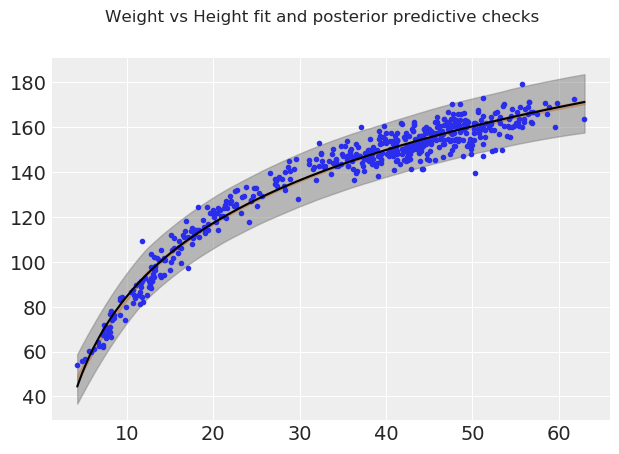

In [35]:
fig, ax = plt.subplots()

ax.plot(weight, height, "C0.")
μ_m = trace_heights["μ"].mean(0)

order = np.argsort(weight)
ax.plot(weight[order], μ_m[order], c="k")

az.plot_hpd(weight, trace_heights["μ"], credible_interval=.98)
az.plot_hpd(weight, ppc_heights["height_pred"], credible_interval=.98, color="gray")

fig.suptitle("Weight vs Height fit and posterior predictive checks");

Let's also plot the noise as a function of weight:

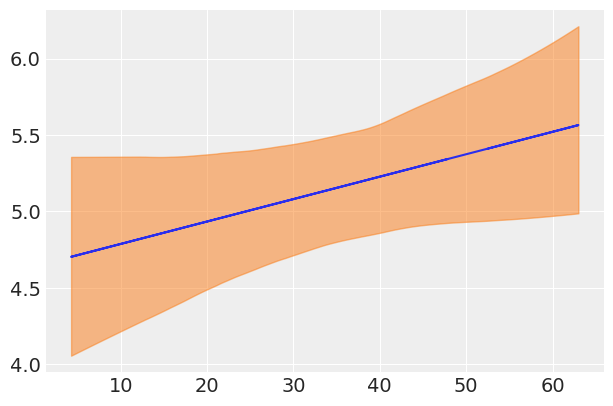

In [38]:
fig, ax = plt.subplots()
ax.plot(weight, trace_heights["ϵ"].mean(0))
az.plot_hpd(weight, trace_heights["ϵ"], credible_interval=.98);

We can see that in lower weight ranges there tends to be less variability in height than for bigger weight ranges (i.e when people are older). This makes sense intuitively, as humans start out roughly the same in their earlier years, and tend to become more different in physical dimensions as they grow older in age and weight.

## Question 10
***

*It is known that for many species the weight does not scale with the height, but with the logarithm of the weight. Use this information to fit the howell data (including subjects from all ages). Do one more model, this time without using the logarithm but instead a second order polynomial. Compare and explain both results.*

We did the logarithm bit in the previous exercise, so let's directly fit the model with a 2nd order polynomial that follows this definition:
$$\mu = \alpha + \beta_0*x + \beta_1*x^2$$

Note that we could have used the dot product like in the `model_mlr` example, but in this model we chose to explicitly split out the terms.

In [39]:
with pm.Model() as heights_polynomial:
    α = pm.Normal("α", sd=10)
    β = pm.Normal("β", sd=10, shape=2)
    γ = pm.HalfNormal("γ", sd=10)
    δ = pm.HalfNormal("δ", sd=10)
    
    weight_shared = shared(weight.values * 1.)
    
    μ = pm.Deterministic("μ", α + β[0] * weight_shared + β[1] * weight_shared**2)
    ϵ = pm.Deterministic("ϵ", γ + δ * weight_shared)
    
    height_pred_polynomial = pm.Normal("height_pred", mu=μ, sd=ϵ, observed=height)
    trace_heights_polynomial = pm.sample(tune=2000)
    ppc_heights_polynomial = pm.sample_posterior_predictive(trace_heights_polynomial, samples=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [δ, γ, β, α]
100%|██████████| 2000/2000 [00:01<00:00, 1282.82it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2ff6bef0>,
      dtype=object)

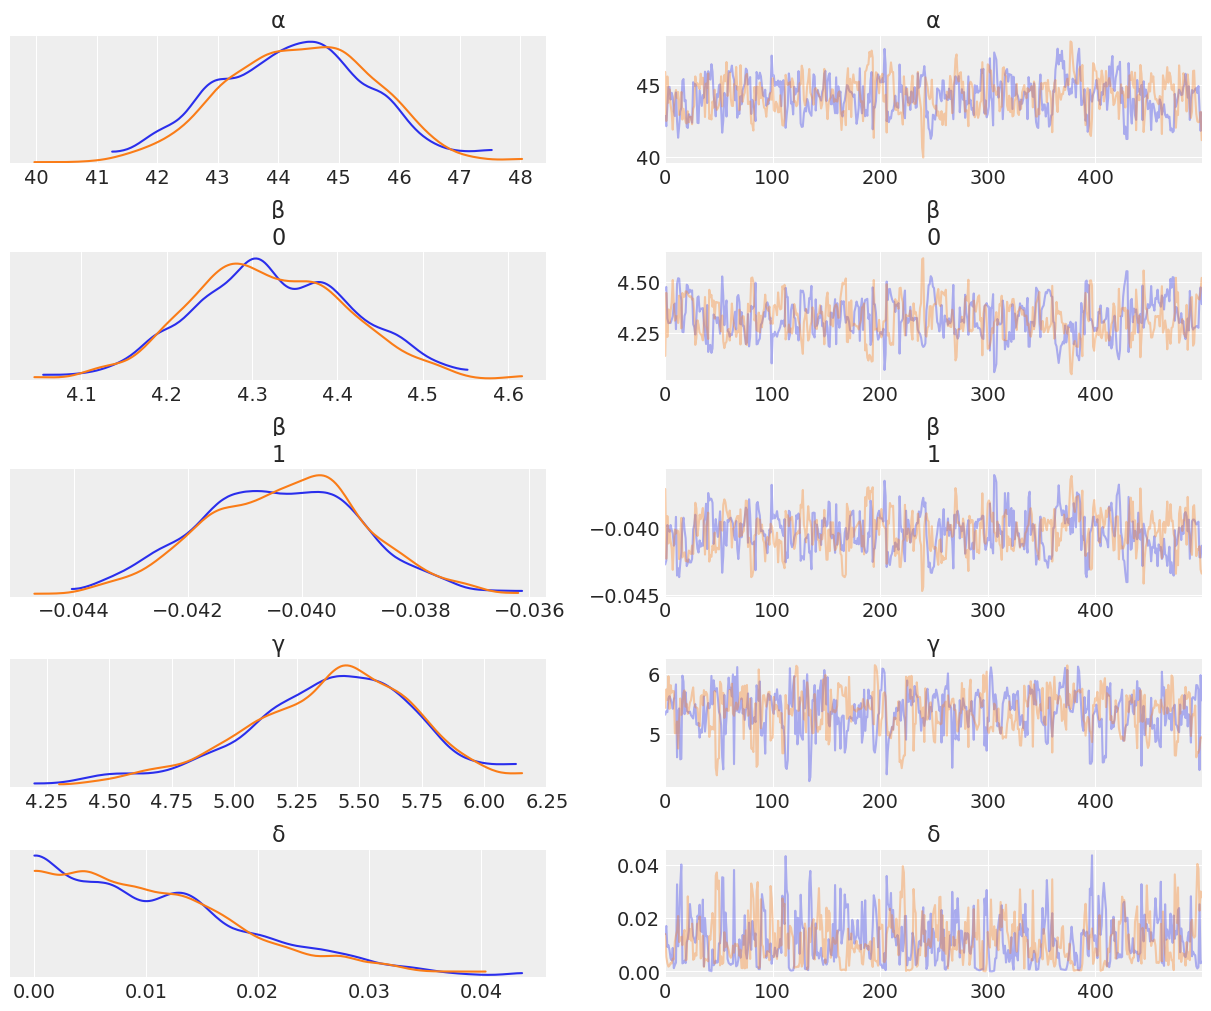

In [40]:
az.plot_trace(trace_heights_polynomial, var_names = ["α","β", "γ", "δ"]);

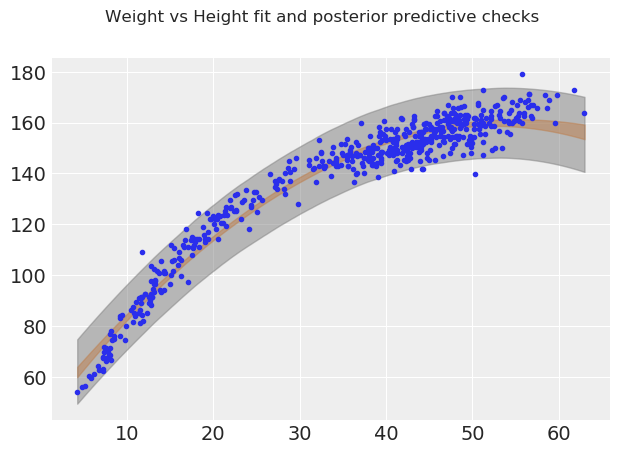

In [41]:
fig, ax = plt.subplots()

ax.plot(weight, height, "C0.")
μ_m = trace_heights_polynomial["μ"].mean(0)
ϵ_m = trace_heights_polynomial["ϵ"].mean(0)

# ax.plot(weight, μ_m, c="k")
az.plot_hpd(weight, trace_heights_polynomial["μ"], credible_interval=.98)
az.plot_hpd(weight, ppc_heights_polynomial["height_pred"], credible_interval=.98, color="gray")
fig.suptitle("Weight vs Height fit and posterior predictive checks");

For weights up until around ~50 units, the polynomial fit looks good. However past that point the curve starts dropping. Inuitively this does not make sense. This phenonemon is not a property of our data, but of our model choice. Polynomial functions always have to make N-1 turns, where N is the degree of the polynomial. This doesn't necessarily make our model useless, it seems to do a good job in certain parts of the domain, but as a statistical modeler, it's up to you to understand the tools in your toolbox and the tradeoffs of each.

## Question 11
***

*Think about a model that's able to fit the first three dataset from the Anscombe quartet. Also, think about a model to fit the fourth dataset.*

Below are all four datasets from Anscombe's Quartet  
![title](images/640px-Anscombe.png)

A model that might fit the first three models is a polynomial regression of the form:

$ y = \alpha_2  x^2 + \alpha_1 x + \alpha_0 $

For the more linear datasets the model could have a low value for $\alpha_2$, and for the second dataset the model would be able to fit the non linearity.

For the last dataset there seems to be two distinct patterns, a cluster of points at x=8 and one at x=19. We could model this one with two groups as follows:

In [3]:
df = pd.read_csv(os.path.join("..", "code", "data", "anscombe.csv"))
df = df.loc[df["group"] == "IV", ["x", "y"]]

In [4]:
idx = (df["x"] == 8).astype(int)
idx

33    1
34    1
35    1
36    1
37    1
38    1
39    1
40    0
41    1
42    1
43    1
Name: x, dtype: int64

In [5]:
with pm.Model() as anscombe:
    
    # Two groups of points with independent parameters
    mu = pm.Normal("mu", sd=10, shape=2)
    sd = pm.HalfNormal("sd", sd=10)
    
    y = pm.Normal("y", mu=mu[idx], sd=sd, observed=df["y"].values)
    
    trace_4 = pm.sample(draws=10000)
    ppc = pm.sample_posterior_predictive(trace_4)

/Users/canyon/.local/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/canyon/.local/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sd]
Sampling 2 chains:   0%|          | 0/21000 [00:00<?, ?draws/s]/Users/ca

/Users/canyon/.local/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c24f9b9b0>,
      dtype=object)

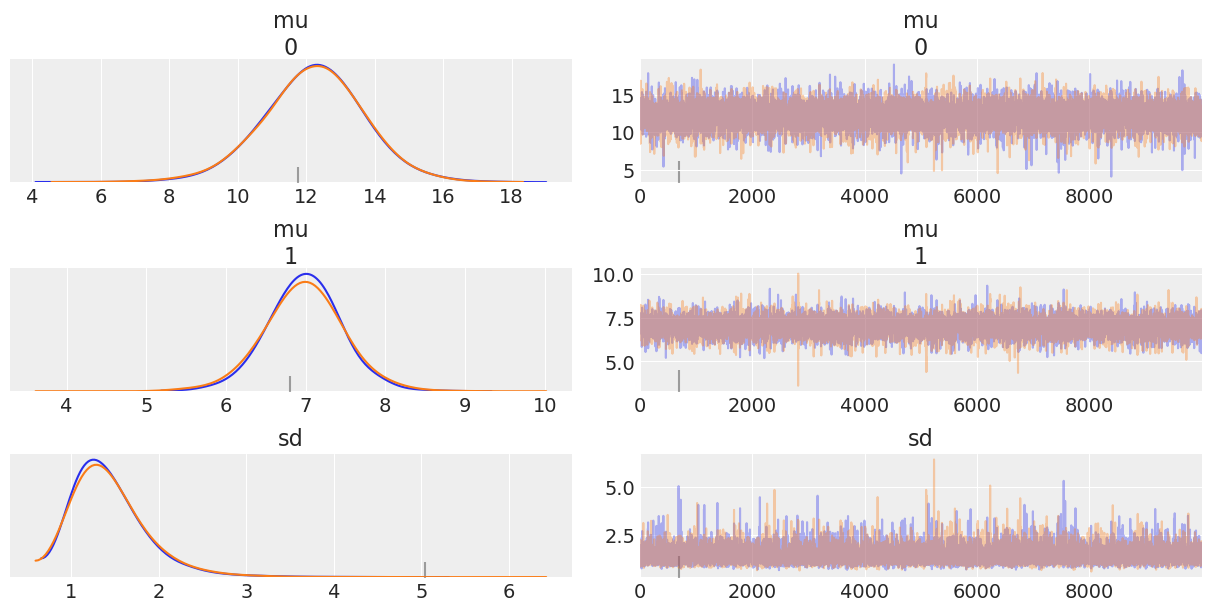

In [6]:
az.plot_trace(trace_4);

## Question 12
***

*See in the code accompanying the book the `model_t2` (and the data associated with it). Experiment with priors for $\nu$, like the non-shifted exponential and gamma priors (they are commented in the code below). Plot the prior distribution, to ensure that you understand them. An easy way to do this is to just comment the likelihood in the model and check the trace plot. A more efficient way though is to use the `pm.sample_prior_predictive()` function instead of `pm.sample()`.*

In [31]:
ans = pd.read_csv('../code/data/anscombe.csv')

In [38]:
x_4 = ans[ans.group == 'IV']['x'].values
y_4 = ans[ans.group == 'IV']['y'].values

with pm.Model() as model_t2:
    α = pm.Normal('α', mu=0, sd=100)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    ν = pm.Exponential('ν', 1/30)
    # ν = pm.Gamma('ν', mu=20, sd=15)
    # ν = pm.Gamma('ν', 2, 0.1)

    y_pred = pm.StudentT('y_pred', mu=α + β * x_4, sd=ϵ, nu=ν, observed=y_4)
    
    prior_v_exp = pm.sample_prior_predictive(2000)
    trace_v_exp = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν, ϵ, β, α]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:16<00:00, 308.57draws/s]


In [39]:
data_exp = az.from_pymc3(trace=trace_v_exp, prior=prior_v_exp)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2fa98dd8>,
      dtype=object)

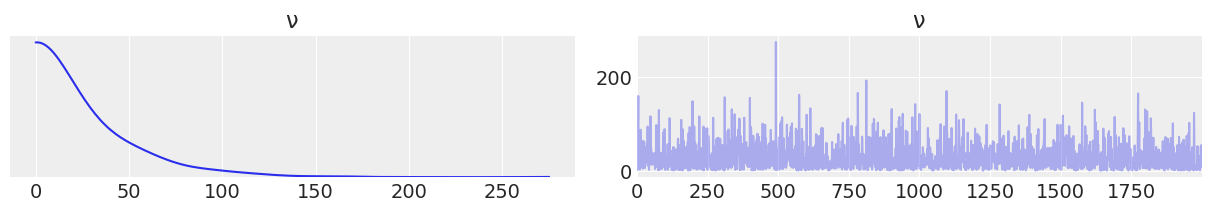

In [40]:
az.plot_trace(data_exp.prior, var_names=["ν"]);

In [32]:
with pm.Model() as model_t2:
    α = pm.Normal('α', mu=0, sd=100)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    # ν = pm.Exponential('ν', 1/30)
    ν = pm.Gamma('ν', mu=20, sd=15)
    #ν = pm.Gamma('ν', 2, 0.1)

    y_pred = pm.StudentT('y_pred', mu=α + β * x_4, sd=ϵ, nu=ν, observed=y_4)
    
    prior_v20_15 = pm.sample_prior_predictive(2000)
    trace_v_20 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν, ϵ, β, α]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:14<00:00, 355.57draws/s]


In [33]:
data_20 = az.from_pymc3(trace=trace_v_20, prior=prior_v20_15)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2ce6af60>,
      dtype=object)

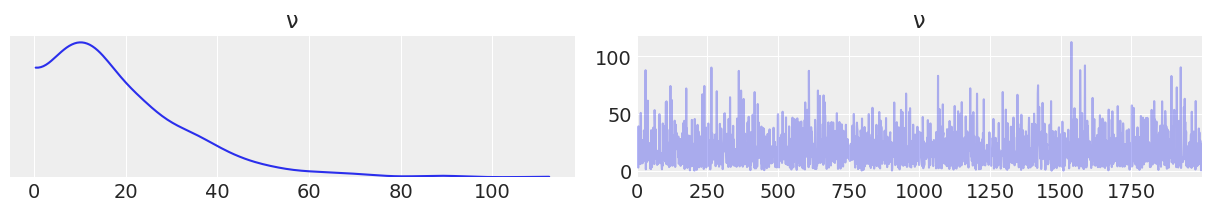

In [34]:
az.plot_trace(data_20.prior, var_names=["ν"]);

In [35]:
with pm.Model() as model_t2:
    α = pm.Normal('α', mu=0, sd=100)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    # ν = pm.Exponential('ν', 1/30)
    # ν = pm.Gamma('ν', mu=20, sd=15)
    ν = pm.Gamma('ν', 2, 0.1)

    y_pred = pm.StudentT('y_pred', mu=α + β * x_4, sd=ϵ, nu=ν, observed=y_4)
    
    prior_v2_01 = pm.sample_prior_predictive(2000)
    trace_v_2_01 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν, ϵ, β, α]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:11<00:00, 453.04draws/s]


In [36]:
data_2 = az.from_pymc3(trace=trace_v_2_01, prior=prior_v2_01)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2cd62208>,
      dtype=object)

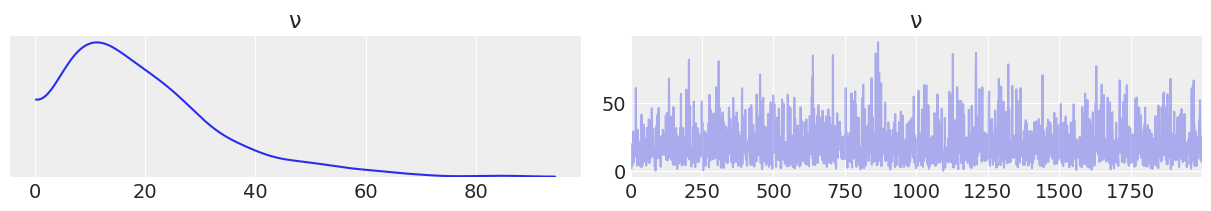

In [37]:
az.plot_trace(data_2.prior, var_names=["ν"]);

## Question 13
***

*For the `unpooled_model`, change the value of `sd` for the $\beta$ prior. Try values of 1 and 100. Explore how the estimated slopes change for each group. Which group is more affected by this change?*

In [ ]:
N = 20
M = 8
idx = np.repeat(range(M-1), N)
idx = np.append(idx, 7)
np.random.seed(314)

alpha_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))

y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m + eps_real
x_centered = x_m - x_m.mean()

Let's loop through a couple standard deviation values for the slope parameter of each group:

In [ ]:
sd_values = [1, 10, 100]
all_traces = {}

for sd_value in sd_values:
    with pm.Model() as unpooled_model:
        α_tmp = pm.Normal('α_tmp', mu=0, sd=10, shape=M)
        β = pm.Normal('β', mu=0, sd=sd_value, shape=M)
        
        ϵ = pm.HalfCauchy('ϵ', 5)
        ν = pm.Exponential('ν', 1/30)

        y_pred = pm.StudentT('y_pred', mu=α_tmp[idx] + β[idx] * x_centered,
                             sd=ϵ, nu=ν, observed=y_m)

        α = pm.Deterministic('α', α_tmp - β * x_m.mean())

        unpooled_model_trace = pm.sample(2000)
        all_traces[sd_value] = unpooled_model_trace

In [ ]:
all_traces[10]

In [ ]:
all_summaries = []
for sd, trace in all_traces.items():
    summary = az.summary(az.from_pymc3(trace=trace))
    summary["group"] =  f"sd_{sd}"
    summary.reset_index(inplace=True)
    #summary. = summary.index +
    all_summaries.append(summary)
    
summaries_df = pd.concat(all_summaries)

In [ ]:
beta = summaries_df[summaries_df["index"].str.contains("β")]
beta = beta[["group", "mean","index"]]

In [ ]:
beta_p = beta.pivot(index="group", columns="index")
beta_p.columns = beta_p.columns.droplevel(0)
beta_p.reset_index(inplace=True)
beta_p

In [ ]:
parallel_coordinates(beta_p, "group")

As we increase the standard deviation of the beta prior (the slope parameter), we see that for most of the groups the effect is neglible. However, for group 7 the prior has a strong effect on the posterior estimation because group 7 only has one data point and the unpooled model doesn't consider the datapoints in the other groups. There simply isn't enough data to "wash out" the prior distribution in this case.

## Question 14
***

*Using the model `hierarchical_model`, repeat Figure 3.18, the one with the eight groups and the eight lines, but this time add the uncertainty to the linear fit.*

In [ ]:
N = 20
M = 8
idx = np.repeat(range(M-1), N)
idx = np.append(idx, 7)
np.random.seed(314)

alpha_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))

y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m + eps_real

with pm.Model() as hierarchical_model:
    # hyper-priors
    α_μ_tmp = pm.Normal('α_μ_tmp', mu=0, sd=10)
    α_σ_tmp = pm.HalfNormal('α_σ_tmp', 10)
    β_μ = pm.Normal('β_μ', mu=0, sd=10)
    β_σ = pm.HalfNormal('β_σ', sd=10)

    # priors
    α_tmp = pm.Normal('α_tmp', mu=α_μ_tmp, sd=α_σ_tmp, shape=M)
    β = pm.Normal('β', mu=β_μ, sd=β_σ, shape=M)
    ϵ = pm.HalfCauchy('ϵ', 5)
    ν = pm.Exponential('ν', 1/30)

    y_pred = pm.StudentT('y_pred', mu=α_tmp[idx] + β[idx] * x_centered,
                         sd=ϵ, nu=ν, observed=y_m)

    α = pm.Deterministic('α', α_tmp - β * x_m.mean())
    α_μ = pm.Deterministic('α_μ', α_μ_tmp - β_μ * x_m.mean())
    α_σ = pm.Deterministic('α_sd', α_σ_tmp - β_μ * x_m.mean())

    trace_hm = pm.sample(1000)
    ppc_lines = pm.sample_posterior_predictive(trace_hm, samples=500)

In [ ]:
alpha = trace_hm.get_values("α")[369, 1]
beta = trace_hm.get_values("β")[369, 1]

In [ ]:
# Get 20 random samples for chain
chain_length =1000
random_draws = np.random.randint(0, chain_length-1, 20)

_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True,
                     constrained_layout=True)
ax = np.ravel(ax)
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10)
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', labelpad=17, rotation=0)
    
    #We add this one line to plot uncertainty. At least two data points must be present in group
    for random_draw in random_draws:
        alpha = trace_hm.get_values("α")[random_draw, i]
        beta = trace_hm.get_values("β")[random_draw, i]
        ax[i].plot(x_m, alpha + beta*x_m, 'C1-', alpha=0.5)
        # ax[i].plot(x_m, alpha + beta*x_m)

    
    alpha_m = trace_hm['α'][:, i].mean()
    beta_m = trace_hm['β'][:, i].mean()
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c='k',
               label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
    plt.xlim(x_m.min()-1, x_m.max()+1)
    plt.ylim(y_m.min()-1, y_m.max()+1)
    j += N
    k += N

## Question 15
***

*Re-run the `model_mlr` example, this time without centering the data. Compare the uncertainty in the $\alpha$ parameter for one case and the other. Can you explain these results?*

*Tip: Remember the definition of the $\alpha$ parameter (also known as the intercept).*

In [ ]:
np.random.seed(314)
N = 100
alpha_real = 2.5
beta_real = [0.9, 1.5]
eps_real = np.random.normal(0, 0.5, size=N)

X = np.array([np.random.normal(i, j, N) for i, j in zip([10, 2], [1, 1.5])]).T
X_mean = X.mean(axis=0, keepdims=True)
# X_centered = X - X_mean
y = alpha_real + np.dot(X, beta_real) + eps_real

In [ ]:
with pm.Model() as model_mlr:
    α_tmp = pm.Normal('α_tmp', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1, shape=2)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α_tmp + pm.math.dot(X, β)

    α = pm.Deterministic('α', α_tmp - pm.math.dot(X_mean, β))

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_mlr = pm.sample(2000)

In [ ]:
az.summary(trace_mlr, var_names=['α', 'β', 'ϵ'])

With the non-centered data, $\alpha$ changes to compensate for the position of the points. In other words, $\alpha$ needs to compensate $\beta X$ distance up or down since the $X$ values are no longer centered around the $y$ axis.

## Question 16
***

*Read and run [this notebook](https://docs.pymc.io/notebooks/LKJ.html) from PyMC3's documentation*

## Question 17
***

*Choose a dataset that you find interesting and use it with the simple linear regression model. Be sure to explore the results using ArviZ functions and compute the Pearson correlation coefficient. If you do not have an interesting dataset, try searching online, for example [here](https://data.worldbank.org/) or [there](http://users.stat.ufl.edu/~winner/datasets.html).*